# Proyek Klasifikasi Gambar: Kendaraan
- **Nama:** Egi Putra Ragil
- **Email:** egiputra450@gmail.com
- **ID Dicoding:** egiputra

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install kaggle

In [ ]:
import os

import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout # Lambda
from tensorflow.keras.callbacks import Callback# EarlyStopping # ModelCheckpoint,
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.activations import relu

## Data Preparation

### Data Loading

In [ ]:
!kaggle datasets download -d mohamedmaher5/vehicle-classification

Dataset URL: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification
License(s): CC0-1.0
 99% 818M/827M [00:13<00:00, 71.6MB/s]
100% 827M/827M [00:13<00:00, 63.1MB/s]


In [ ]:
!unzip vehicle-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (630).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (631).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (632).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (633).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (634).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (635).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (636).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (637).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (638).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (639).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (64).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (640).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (641).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (642).JPG  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (643).jpg  
  inf

In [ ]:
import os
os.listdir('Vehicles')

['Motorcycles', 'Planes', 'Cars', 'Bikes', 'Trains', 'Ships', 'Auto Rickshaws']

In [ ]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_directory = os.path.join(subdir_path, img_file)
            if img_directory.endswith('.gif'):
                cap = cv2.VideoCapture(img_directory)
                ret, image = cap.read()
                cap.release()
            else:
                image = cv2.imread(img_directory)

            unique_sizes.add(image.shape[:2])

    for size in unique_sizes:
        print(f"- {size}")
    print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution('./Vehicles')

Bikes: 800
Cars: 790
Motorcycles: 800
Ships: 800
Planes: 800
Auto Rickshaws: 800
Trains: 800
- (1200, 1600)
- (360, 540)
- (1438, 2560)
- (551, 1276)
- (436, 800)
- (343, 609)
- (655, 1024)
- (900, 1200)
- (40, 162)
- (1495, 1495)
- (200, 300)
- (792, 620)
- (257, 196)
- (734, 1024)
- (723, 1280)
- (270, 480)
- (613, 999)
- (209, 241)
- (600, 800)
- (140, 141)
- (350, 625)
- (70, 162)
- (641, 917)
- (1935, 3199)
- (99, 225)
- (2211, 3777)
- (704, 1122)
- (4000, 3000)
- (866, 1300)
- (300, 480)
- (250, 250)
- (686, 960)
- (698, 1200)
- (365, 645)
- (140, 118)
- (201, 250)
- (221, 228)
- (186, 270)
- (813, 777)
- (875, 1246)
- (101, 162)
- (707, 1024)
- (133, 380)
- (441, 761)
- (2129, 3199)
- (175, 233)
- (52, 162)
- (515, 1204)
- (596, 900)
- (350, 350)
- (1746, 2500)
- (261, 421)
- (255, 198)
- (140, 131)
- (225, 355)
- (2056, 2576)
- (197, 256)
- (854, 1280)
- (850, 901)
- (720, 1200)
- (492, 964)
- (532, 1000)
- (458, 1200)
- (666, 1000)
- (213, 237)
- (151, 225)
- (2159, 3348)
- (4

In [ ]:
def load_image(directory: str, size: tuple, vmax: int=255):
    """
    Function for loading image dataset
    Args:
    Keyword arguments:
    directory: str  -- dataset directory
    vmax: int       -- normalization value
    size: tuple     -- image size
    Returns:
    Tuple(images: np.array, labels: np.array)
    """
    images = []
    labels = []

    print("Loading {}".format(directory))

    # Iterate through each folder corresponding to a category
    for label, folder in enumerate(os.listdir(directory)):
        for file in tqdm(os.listdir(os.path.join(directory, folder))):

            # Get the directory name of the image
            img_directory = os.path.join(os.path.join(directory, folder), file)

            # Open and resize the img
            if img_directory.endswith('.gif'):
                cap = cv2.VideoCapture(img_directory)
                ret, image = cap.read()
                cap.release()
            else:
                image = cv2.imread(img_directory, 1)

            image = cv2.resize(image, size)
            # Convert to RGB if necessary
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if vmax == 1:
                image = image / 255
            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype=np.float32 if vmax == 1 else np.uint8)
    labels = np.array(labels, dtype=np.uint8)

    return (images, labels)

In [ ]:
images, labels = load_image('./Vehicles', size=(224, 224), vmax=1)

Loading ./Vehicles


100%|██████████| 800/800 [00:03<00:00, 208.26it/s]


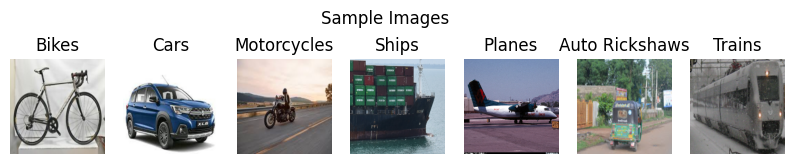

In [ ]:
classes = os.listdir('Vehicles')

fig, axs = plt.subplots(ncols=len(classes), figsize=(10, 2))
fig.suptitle('Sample Images')
for i, label in enumerate(classes):
    axs[i].imshow(images[labels==i][0])
    axs[i].set_title(label)
    axs[i].set_axis_off()

plt.show()

### Data Preprocessing

#### Split Dataset

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, train_size=0.8, random_state=42
)

In [ ]:
def show_distribution_class(train, val, title):
    classes = os.listdir('./Vehicles')
    class_counts = {
        'Training': [
            train[train==i].shape[0] for i in range(len(classes))
        ],
        'Validation': [
            val[val==i].shape[0] for i in range(len(classes))
        ]
    }

    x = np.arange(len(classes))
    width = 0.25
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in class_counts.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Jumlah')
    ax.set_title(title)
    ax.set_xticks(x + width, classes)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1000)

    plt.show()

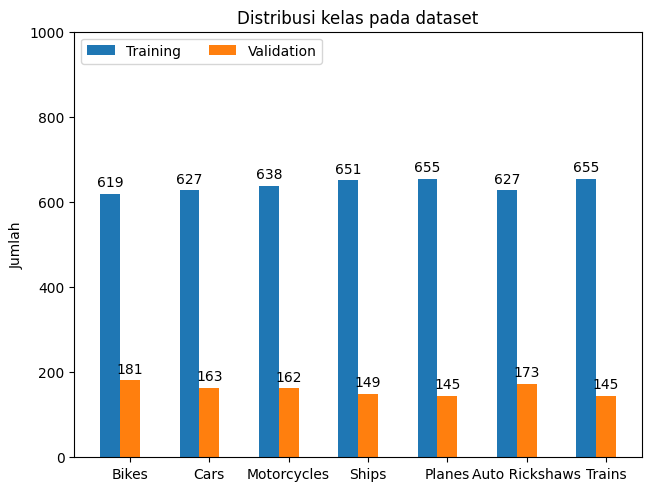

In [ ]:
show_distribution_class(y_train, y_val, 'Distribusi kelas pada dataset')

## Modelling

In [ ]:
# Menggunakan TPU untuk training
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    model = Sequential([
        Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding='same', activation='relu'),
        Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'),
        Flatten(name='flatten'),
        Dense(256, activation='relu', name='fc1'),
        Dropout(0.4),
        Dense(128, activation='relu', name='fc2'),
        Dropout(0.15),
        Dense(len(classes), activation='softmax', name='output')
    ], name="VGG16")
    # model = Sequential([
    #     Conv2D(input_shape=(227, 227, 3), filters=96, kernel_size=11, strides=4, padding='same'),
    #     Lambda(tf.nn.local_response_normalization),
    #     Lambda(relu),
    #     MaxPool2D(3, strides=2),
    #     Conv2D(256, 5, strides=4, padding='same'),
    #     Lambda(tf.nn.local_response_normalization),
    #     Lambda(relu),
    #     MaxPool2D(3, strides=2),
    #     Conv2D(384, 3, strides=4, padding='same'),
    #     Lambda(relu),
    #     Conv2D(384, 3, strides=4, padding='same'),
    #     Lambda(relu),
    #     Conv2D(256, 3, strides=4, padding='same'),
    #     Lambda(relu),
    #     Flatten(),
    #     Dense(4096, activation='relu'),
    #     Dropout(0.5),
    #     Dense(4096, activation='relu'),
    #     Dropout(0.5),
    #     Dense(len(classes), activation='softmax'),
    # ], name="Alexnet")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        metrics=['accuracy']
    )

    model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_84 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_85 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_86 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                       

In [ ]:
class MyEarlyStopping(Callback):
    def __init__(self, threshold=0.85):
        super(Callback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.threshold:
            self.model.stop_training = True

In [ ]:
# Assuming y_train_augmented and y_val are currently integer-encoded
y_train = to_categorical(y_train, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))

In [ ]:
batch_size = 100

# Melatih model
history = model.fit(
    X_train,
    y_train,
    verbose=True,
    batch_size=batch_size,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[MyEarlyStopping()]
)

Epoch 1/40
45/45 [==============================] - 60s 852ms/step - loss: 0.3575 - accuracy: 0.1505 - val_loss: 0.3574 - val_accuracy: 0.1324
Epoch 2/40
45/45 [==============================] - 7s 163ms/step - loss: 0.3406 - accuracy: 0.2120 - val_loss: 0.2990 - val_accuracy: 0.3488
Epoch 3/40
45/45 [==============================] - 7s 163ms/step - loss: 0.2663 - accuracy: 0.3945 - val_loss: 0.2353 - val_accuracy: 0.4678
Epoch 4/40
45/45 [==============================] - 7s 163ms/step - loss: 0.2145 - accuracy: 0.5078 - val_loss: 0.1958 - val_accuracy: 0.5546
Epoch 5/40
45/45 [==============================] - 7s 164ms/step - loss: 0.1714 - accuracy: 0.5935 - val_loss: 0.1591 - val_accuracy: 0.6154
Epoch 6/40
45/45 [==============================] - 7s 163ms/step - loss: 0.1399 - accuracy: 0.6541 - val_loss: 0.1202 - val_accuracy: 0.7200
Epoch 7/40
45/45 [==============================] - 7s 164ms/step - loss: 0.1210 - accuracy: 0.7048 - val_loss: 0.1145 - val_accuracy: 0.7343
Epoch

## Evaluasi dan Visualisasi

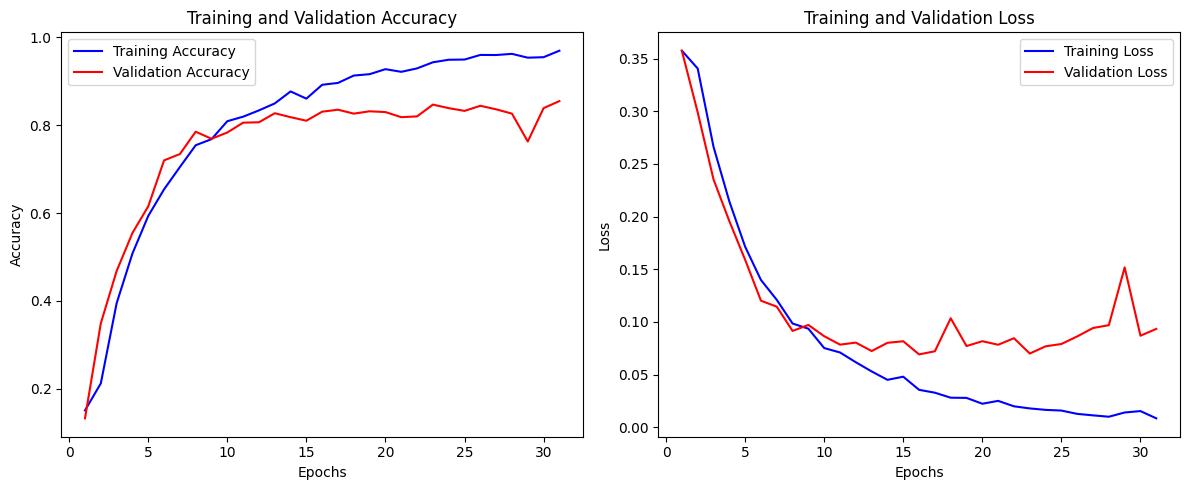

In [ ]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Define the number of epochs
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # Create a 1x2 subplot
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)  # Create a 1x2 subplot
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

plot_metrics(history)

In [ ]:
results = model.evaluate(X_val, y_val)
print("test loss : ", results[0])
print("test acc: ", results[1])

35/35 [==============================] - 1s 24ms/step - loss: 0.0934 - accuracy: 0.8551
test loss :  0.0934295505285263
test acc:  0.8550983667373657


## Konversi Model

In [ ]:
tf.saved_model.save(model, "saved_model")

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 920.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstall

In [ ]:
!tensorflowjs_converter \
    --input_format tf_saved_model \
    saved_model \
    tfjs_model

2024-09-02 04:29:49.286801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 04:29:49.306717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 04:29:49.312577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 04:29:50.292362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1725251393.217277   53302 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with tf.io.gfile.GFile('vgg16.tflite', 'wb') as f:
    f.write(tflite_model)

## Inference (Optional)